# Load data and add indicators

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('..')

from os import environ
import numpy as np
import pandas as pd
from indicators import indicators
from datetime import timedelta
from tqdm.auto import tqdm
from config.config import ConfigFactory

# Set environment variable
environ["ENV"] = "1h_4h"

# Get configs
configs = ConfigFactory.factory(environ).configs

# Should we create new dataset or load previous
collect = False

def get_file(ticker):
    ''' Find files buy ticker names, file names can be in different formats '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        pass
    else:
        return tmp_df_1h, tmp_df_4h
    
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}_4h.pkl')
    except FileNotFoundError:
        pass
    else:
        return tmp_df_1h, tmp_df_4h
    
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}-SWAP_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker[:-4]}-{ticker[-4:]}-SWAP_4h.pkl')
    except FileNotFoundError:
        pass
    else:
        return tmp_df_1h, tmp_df_4h
    
    return None, None

def add_indicators(df, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add RSI
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df = trend.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df = macd.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add SMA
    # sma = indicators.SMA(ttype, configs)
    # df = sma.get_indicator(df, '', '', 0)
    return df

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        tmp_df_1h = add_indicators(tmp_df_1h, ttype, configs)

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + step, step):
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, :].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue
            
            # add target
            time_next = t + timedelta(hours=target_offset)
            if ttype == 'buy':
                target = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'high'].reset_index(drop=True)
            else:
                target = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'low'].reset_index(drop=True)

            target.name = 'target'
            rows = pd.concat([row, target], axis=1)
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = rows
            else:
                train_df = pd.concat([train_df, rows])
    
    return train_df

if collect is True:
    # for how long time (in hours) we want to predict
    target_offset = 24
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 48
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_df = pd.concat([train_buy, train_sell]).sort_values('time').reset_index(drop=True)
    train_df.to_pickle('signal_stat/train_df.pkl')
else:
    train_df = pd.read_pickle('signal_stat/train_df.pkl')

display(train_df.head())
display(train_df.shape)


,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,...,linear_reg_prev_48,linear_reg_angle_prev_48,macd_prev_48,macdsignal_prev_48,macdhist_prev_48,macd_dir_prev_48,macdsignal_dir_prev_48,atr_prev_48,close_smooth_prev_48,target
0,2022-09-10 21:00:00,0.99990,0.99990,0.9998,0.99980,227818.000,58.380200,35.714286,34.523810,0.205808,...,22.072420,3.511172,-0.000010,-0.000008,-0.000002,0.488404,-0.017765,0.000108,0.999946,0.99980
1,2022-09-15 15:00:00,1.00000,1.00000,0.9999,1.00000,250135.000,58.463239,64.285714,53.174603,0.357436,...,16.768418,-3.329827,-0.000006,0.000005,-0.000011,-0.302160,-0.266478,0.000111,0.999804,1.00010
2,2022-09-21 19:00:00,1.00000,1.00000,0.9999,0.99990,49801.000,45.480088,57.142857,61.904762,-0.066667,...,38.183518,2.280714,-0.000016,-0.000006,-0.000010,0.359671,1.111904,0.000115,1.000008,1.00010
3,2022-12-24 12:00:00,68.10000,69.10000,68.0000,68.70000,1712.657,25.443832,13.872597,11.125943,0.187309,...,35.878666,10.537428,0.487438,0.885719,-0.398280,0.000000,-0.079996,1.140238,73.870833,70.30000
4,2022-12-24 20:00:00,0.01983,0.01986,0.0198,0.01983,2034435.500,39.251422,48.677324,51.357005,0.000399,...,9.486056,-10.186354,-0.000034,-0.000007,-0.000027,0.893395,0.167818,0.000150,0.020048,0.01943


(11581, 264)

# Pytorch

### Create dataset

In [2]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler

test_size=0.2

x_data = train_df.drop(['target', 'time', 'ticker', 'pattern'], axis=1)
y_data = train_df['target'] >= train_df['close']
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)

scaler = StandardScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train)
x_valid[x_valid.columns] = scaler.transform(x_valid)

x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.float32)

display(type(x_train), type(y_train))

torch.Tensor

torch.Tensor

### Find available device

In [3]:
# find available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Build model

In [4]:
class SigModel(torch.nn.Module):
    def __init__(self):
        super(SigModel, self).__init__()
        self.layers = torch.nn.Sequential()
        self.layers.add_module('lin1', torch.nn.Linear(260, 64))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('do1', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin2', torch.nn.Linear(64, 128))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('do2', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin3', torch.nn.Linear(128, 96))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('do3', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin4', torch.nn.Linear(96, 32))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('do4', torch.nn.Dropout(p=0.25))
        self.layers.add_module('lin5', torch.nn.Linear(32, 1))
        self.layers.add_module('sigmoid', torch.nn.Sigmoid())
    
    def forward(self, input):
        return self.layers(input)

# Train model

In [5]:
from torch import nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

# train function
def train_epoch(model, train_loader, criterion, optimizer, scheduler):
    # put the model in train mode
    model.train()
    
    x_train, x_valid, y_train, y_valid = train_loader

    # get output of the model
    train_preds = model(x_train).squeeze()
    # calculate train loss
    train_loss = criterion(train_preds, y_train)
    train_acc = (train_preds.round() == y_train).float().mean()
    
    # set gradient to zero to prevent it accumulation
    optimizer.zero_grad() # ~ model.zero_grad()
    # calculate gradient
    train_loss.backward() 
    # update weights
    optimizer.step()
    
    # put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        val_preds = model(x_valid).squeeze()
        val_loss = criterion(val_preds, y_valid)
        val_acc = (val_preds.round() == y_valid).float().mean()
    
    # update weights according to gradient value
    scheduler.step(val_loss)
    
    return train_loss, train_acc, val_loss, val_acc

# Initialize model
model = SigModel().to(device)

# Number of epochs
epochs = 10000

# Send data to the device
x_train, x_valid = x_train.to(device), x_valid.to(device)
y_train, y_valid = y_train.to(device), y_valid.to(device)
train_loader = x_train, x_valid, y_train, y_valid

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

criterion = nn.BCELoss()
learning_rate = 1e-6
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2000, threshold=1e-2)

# Loop through the data
for epoch in range(epochs):
    train_loss, train_acc, val_loss, val_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)

    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}\
            Validation Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}\
                LR: {optimizer.state_dict()["param_groups"][0]["lr"]}')

        epoch_count.append(epoch)
        train_loss_values.append(train_loss.cpu().detach().numpy())
        valid_loss_values.append(val_loss.cpu().detach().numpy())


Epoch:    0 | Train Loss: 0.69777, Train Acc: 0.46848            Validation Loss: 0.73827, Val Acc: 0.48425                LR: 1e-06
Epoch:  500 | Train Loss: 0.69701, Train Acc: 0.47042            Validation Loss: 0.78139, Val Acc: 0.48468                LR: 1e-06


# Plot the results

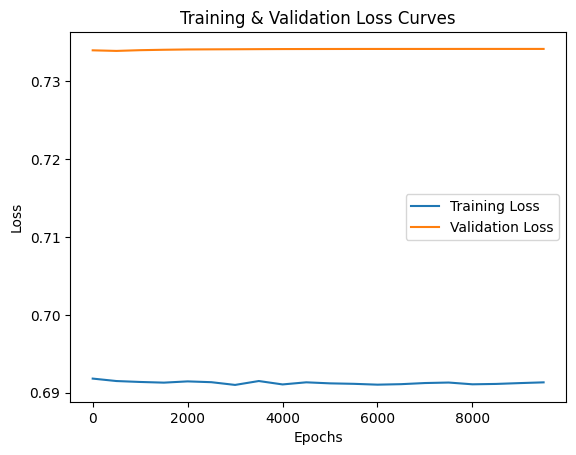

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Select features

In [2]:
import lightgbm as lgb

from eli5.sklearn import PermutationImportance
from shaphypetune import BoostBoruta

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

from sklearn.metrics import log_loss, mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings('ignore')

from colorama import Style, Fore

palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

class CFG:
    n_repeats = 1
    n_folds = 5

def lgbm_tuning(df, permut=False, boruta=False):
    features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern']]
    groups = df['ticker']

    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    boruta_df_ = pd.DataFrame()
    
    for i in range(CFG.n_repeats):
        print(f'Repeat {blu}#{i+1}')
        
        if task_type == 'cls':
            y_fold = df['target'] >= df['close']
            kf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=180820231)
            eval_metric = 'logloss'
        else:
            y_fold = (df['target'] - df['close']) / df['close']
            kf = GroupKFold(n_splits=CFG.n_folds)
            eval_metric = 'mse'

        X, y = df[features], y_fold
        oof = np.zeros(len(df))
        models_ = [] # Used to store models trained in the inner loop.
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y, groups)):
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            if task_type == 'cls':
                clf = lgb.LGBMClassifier(**params)
            else:
                clf = lgb.LGBMRegressor(**params)
            clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            models_.append(clf)

            if task_type == 'cls':
                val_preds = clf.predict_proba(X_val)[:,1]
                val_score = log_loss(y_val, val_preds)
            else:
                val_preds = clf.predict(X_val)
                val_score = mean_squared_error(y_val, val_preds, squared=False)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
                    
            # BORUTA importance
            if boruta:
                model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False)
                try:
                    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                            eval_metric=eval_metric, 
                            callbacks=[lgb.log_evaluation(100)])
                except RuntimeError:
                    continue
                
                boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, 
                                                        index=X_train.columns).sort_index()
                if boruta_df_.shape[0] == 0:
                    boruta_df_ = boruta_importance_df.copy()
                else:
                    boruta_df_ += boruta_importance_df

        if task_type == 'cls':
            outer_cv = log_loss(y, oof)
        else:
            outer_cv = mean_squared_error(y, oof, squared=False)
        
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
        
    if boruta:
        boruta_df_ = boruta_df_.sort_values('importance')
        boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, boruta_df_, np.mean(outer_cv_score)


params = {
          'n_estimators': 1000,
          'learning_rate': 0.01,
          'early_stopping_round': 100,
          'max_depth': 7,
          'subsample' : 0.8,
          'colsample_bytree': 0.75,
          'num_leaves': 32,
          'verbosity': -1,
          'importance_type': 'gain'
        }

task_type = 'cls'

if task_type == 'cls':
    params['boosting_type'] = 'dart'
    params['objective'] = 'binary'
else:
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'

perm_df_, feature_importances_, boruta_df_, outer_cv_score = lgbm_tuning(train_df, permut=True, boruta=True)

/home/alex/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/alex/.local/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_

Repeat #1
[100]	training's binary_logloss: 0.664634	valid_1's binary_logloss: 0.677546
[200]	training's binary_logloss: 0.651138	valid_1's binary_logloss: 0.672401
[300]	training's binary_logloss: 0.636059	valid_1's binary_logloss: 0.667498
[400]	training's binary_logloss: 0.622097	valid_1's binary_logloss: 0.663483
[500]	training's binary_logloss: 0.608386	valid_1's binary_logloss: 0.660385
[600]	training's binary_logloss: 0.60259	valid_1's binary_logloss: 0.659508
[700]	training's binary_logloss: 0.592565	valid_1's binary_logloss: 0.657351
[800]	training's binary_logloss: 0.585903	valid_1's binary_logloss: 0.656394
[900]	training's binary_logloss: 0.576039	valid_1's binary_logloss: 0.654738
[1000]	training's binary_logloss: 0.569051	valid_1's binary_logloss: 0.653508
Fold:   1| loss: 0.65351| Best iteration:    0
[100]	training's binary_logloss: 0.6635	valid_1's binary_logloss: 0.680149
[200]	training's binary_logloss: 0.650273	valid_1's binary_logloss: 0.674954
[300]	training's bina

# Combine importances and save them

In [6]:
perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
boruta_df_['rank'] = boruta_df_['importance'].rank()
feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

res = pd.concat([perm_df_[['Feature','rank']], boruta_df_[['Feature','rank']], feature_importances_[['Feature','rank']]])
res = res.groupby('Feature')['rank'].sum().sort_values()
res.to_csv('feature_importance.csv')

# Train model with selected features

In [57]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, LinearRegression


def model_train(df, task_type, how, n_folds): 
    oof = np.zeros([df['target'].shape[0], 1])
    # features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern']]
    features = res.groupby('Feature')['rank'].sum().sort_values().head(200).index.to_list()

    X, groups = df[features], df['ticker']
    X = pd.concat([X, pd.get_dummies(df['pattern'], drop_first=True)], axis=1)
    
    if task_type == 'cls':
        y = df['target'] >= df['close']
        kf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=180820231)
    else:
        y = (df['target'] - df['close']) / df['close']
        kf = GroupKFold(n_splits=n_folds)

    oe_enc = OrdinalEncoder()
    groups = oe_enc.fit_transform(groups.values.reshape(-1, 1))

    print(f"Training with {len(features)} features")
    
    if how == 'lreg':
        scaler = StandardScaler()
        X[X.columns] = scaler.fit_transform(X)
    
    for fold, (fit_idx, val_idx) in enumerate(kf.split(X, y, groups)):
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[fit_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[fit_idx]
        y_val = y.iloc[val_idx]
        
        models = list()
        if how == 'lgbm':
            if task_type == 'cls':
                model = lgb.LGBMClassifier(**params)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                        eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
                # best_iter = model.best_iteration_
            else:
                model = lgb.LGBMRegressor(**params)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                        eval_metric='mse', callbacks = [lgb.log_evaluation(100)])
                # best_iter = model.best_iteration_
        elif how == 'lreg':
            if task_type == 'cls':
                model = LogisticRegression(C=0.1, max_iter=100000)#, class_weight='balanced')
                model.fit(X_train, y_train)
            else:
                model = LinearRegression(positive=True)
                model.fit(X_train, y_train)

        if task_type == 'cls':
            val_preds = model.predict_proba(X_val)
            val_score = log_loss(y_val, val_preds)
            acc_score = confident_accuracy_score(y_val, val_preds[:,1])
            print(f'Logloss: {val_score}, Confident objects accuracy: {acc_score}')
            oof[val_idx, 0] = val_preds[:,1]
        else:
            val_preds = model.predict(X_val)
            val_score = mean_squared_error(y_val, val_preds, squared=False)
            print('RMSE: {val_score}')
            oof[val_idx, 0] = val_preds
        
        models.append(model)
        
    return oof, models

def confident_accuracy_score(y, oof, low_bound=0.35, high_bound=0.65):
    ''' Consider only high confident objects for accuracy score calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf[oof < low_bound] = 0
    pred_conf = pred_conf[(oof < low_bound) | (oof > high_bound)]

    y_conf = y.values.reshape(-1,1)[(oof < low_bound) | (oof > high_bound)]

    return accuracy_score(y_conf, pred_conf)   

# task_type = 'reg'
task_type = 'cls'

# best params for classification
if task_type == 'cls':
    params = {
            'boosting_type': 'dart',
            'n_estimators': 900,
            'learning_rate': 0.02,
            #   'early_stopping_round': 50,
            'max_depth': 10,
            'colsample_bytree': 0.75,
            'subsample': 0.9,
            'subsample_freq': 1,
            'num_leaves': 26,
            'verbosity': -1,
            'max_bin': 255,
            'reg_alpha': 1e-5,
            'reg_lambda': 1e-7,
            'objective': 'binary'
            }
else:
    # best params for regression
    params = {
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'learning_rate': 0.021,
            'early_stopping_round': 100,
            'max_depth': 7,
            'colsample_bytree': 0.75,
            'subsample': 0.8,
            'subsample_freq': 1,
            'num_leaves': 27,
            'verbosity': -1,
            'max_bin': 511,
            'reg_alpha': 1e-4,
            'reg_lambda': 1e-4,
            'objective': 'regression'
            }

oof, models = model_train(train_df, task_type=task_type, how='lgbm', n_folds=5) # 0.061096263508601985 / logloss: 0.6226973017816237 acc: 0.6424792139077853
# oof, models = model_train(train_df, task_type=task_type, how='lreg', n_folds=5) # 0.06958035063954768 / logloss: 0.6985539186132326 acc: 0.587892049598833

if task_type == 'cls':
    y = train_df['target'] >= train_df['close']
    low_bound, high_bound = 0.3, 0.7
    display(log_loss(y, oof))
    display(confident_accuracy_score(y, oof, low_bound, high_bound))
else:
    y = (train_df['target'] - train_df['close']) / train_df['close']
    display(mean_squared_error(y, oof, squared=False))


NameError: name 'res' is not defined

In [ ]:
# 0.6548368650163564

# 0.8207831325301205